<a href="https://colab.research.google.com/github/rzninvo/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Editor:** [Roham Zendehdel](https://github.com/rzninvo/)  
**Description:** In this notebook, we want to classify the Ronash dataset into 20 categories. The original code has a accuracy of 82% and an average loss of 0.78. I'll be attempting to try different models and tune the hyperparameters to reach a better accuracy and loss. 

## Initialization
We download the dataset and import the library requirements.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [3]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 148MB/s]


In [4]:
ls

Ronash_DS_Assignment.csv  sample_data/


As we can see, the Ronash dataset has been succesfully downloaded.

In [5]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


In [6]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [7]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [8]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset so we can ignore them.

## Data Preprocessing
Preprocessing is an important step in machine learning. In text classification we need to tokenize and vectozire our senteces so that our model can understand relations between the words in a sentece.

### Tokenizing and Standardizing
Tokenize and standardizing the sentences. Also filtering the words based on a predefined regex. 

In [9]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [10]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5265,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5266,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5267,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5268,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [11]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [12]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


### Data sampling
After standardizing the dataset, It's time to **split** the dataset into train dataset and test datasets. The selected ratio of data is 80% of the dataset for training and 20% of the dataset is for testing and validation. 50% of the testing dataset is for validation and the rest is for testing our model.

In [13]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


### Batching
We need to split our datasets into 32 sized batches.

In [14]:
# creating data generators with batch size 32
batch_size = 32
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys '
 b'foldable waterproof raised dog bed dogiti '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'quay vip pink navy to pink lens quay accessories new summer sunglasses '
 b'seachem multitest ammonia seachem '
 b'sma

In [14]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print(num_of_words)

112572


There are about 112000 words in the texts.



In [15]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_length = 0
for i in dataset['text']:
  length = len(i.split())
  if length > max_seq_length: max_seq_length = length
  for j in i.split():
    if j not in l: l.append(j)

print(max_seq_length)
print(len(l))

309
18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350. 
    
**Edits:** Original code had set the maximum features to 10000. I'll be using the entire features with a maximum length of 310

### Vectorizing the datasets
Each sentece has a word vector with a length of 350. Each unique word is mapped to a number between 0 and 10000

In [16]:
# setting the text vectorization layer with 20000 words and 350 sequence length
max_features = 10000
sequence_length = 350

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys ', shape=(), dtype=string)
Label tf.Tensor(18, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 350), dtype=int64, numpy=
array([[   1, 9229,  192,   23,  343,   51, 1546, 2392, 9089, 9635,  740,
        1609,  275, 2882,  372,   69,  959,    1,  134,  109,   89,  275,
        2882,   35,   55,  381,   16,  480, 7346,  783,  181,  783,  961,
         783,  134,   79, 2792,  

In [17]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  heel
 313 --->  is
Vocabulary size: 10000


In [18]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Building the Model
In this section we'll build our text classifier model.

In [ ]:
# model configuration
embedding_dim = 32
num_of_labels = 20
vocab_size = len(vectorize_layer.get_vocabulary())

model = tf.keras.Sequential([
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 320,692
Trainable params: 320,692
Non-trainable params: 0
________________________________________________

In [ ]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
132/132 [==============================] - 3s 16ms/step - loss: 2.8733 - accuracy: 0.1800 - val_loss: 2.7578 - val_accuracy: 0.1898
Epoch 2/500
132/132 [==============================] - 3s 21ms/step - loss: 2.7064 - accuracy: 0.1881 - val_loss: 2.6873 - val_accuracy: 0.1898
Epoch 3/500
132/132 [==============================] - 2s 14ms/step - loss: 2.6782 - accuracy: 0.1881 - val_loss: 2.6749 - val_accuracy: 0.1898
Epoch 4/500
132/132 [==============================] - 2s 13ms/step - loss: 2.6673 - accuracy: 0.1881 - val_loss: 2.6678 - val_accuracy: 0.1898
Epoch 5/500
132/132 [==============================] - 2s 16ms/step - loss: 2.6618 - accuracy: 0.1881 - val_loss: 2.6608 - val_accuracy: 0.1898
Epoch 6/500
132/132 [==============================] - 4s 31ms/step - loss: 2.6561 - accuracy: 0.1881 - val_loss: 2.6540 - val_accuracy: 0.1898
Epoch 7/500
132/132 [==============================] - 2s 18ms/step - loss: 2.6481 - accuracy: 0.1883 - val_loss: 2.6460 - val_accuracy:

In [ ]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

17/17 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.8349
Loss:  0.6911157965660095
Accuracy:  0.8349146246910095


In [ ]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

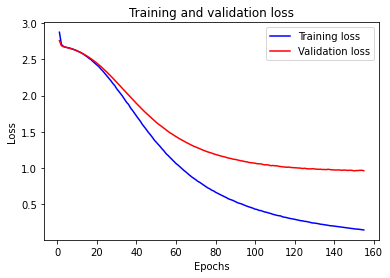

In [ ]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

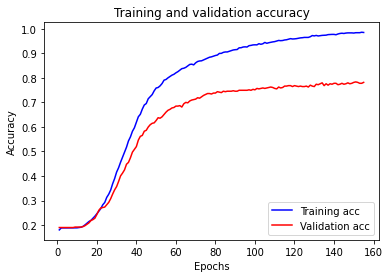

In [ ]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

17/17 [==============================] - 0s 2ms/step


In [ ]:
# showing the first test sample result label
np.argmax(predictions[0])

12

In [ ]:
# showing the true label of the first test sample
test_df.iloc[0]

text         herschel sulfur spring olive night reflective ...
label                                           Luggage & Bags
label_int                                                   12
Name: 3686, dtype: object

**Author:** https://farrokhkarimi.github.io/

# Hyperparameter tuning  
In this section, I will be testing different hyperparameters using Keras RandomSearch.

**Editor:** [Roham Zendehdel Nobari](https://github.com/rzninvo\)

In [ ]:
#Clearing Keras data on RAM.
tf.keras.backend.clear_session()

Installing keras tuner

In [25]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00


## Basic Changes

Creating a function for spliting train and test datasets with arbitrary percentages.

In [17]:
def split_train_test_datasets(dataset, test_size, val_frac):
  # splitting dataset to train, validation, and test dataframes
  train_df, test_df= train_test_split(dataset, test_size= test_size, random_state=42)
  val_df = test_df.sample(frac= val_frac)
  test_df.drop(val_df.index, inplace=True)

  print(f"Number of samples in training set: {len(train_df)}")
  print(f"Number of samples in validation set: {len(val_df)}")
  print(f"Number of samples in test set: {len(test_df)}")

  # extracting texts and labels from dataframes
  train_texts = train_df['text']
  train_labels = train_df['label_int']
  val_texts = val_df['text']
  val_labels = val_df['label_int']
  test_texts = test_df['text']
  test_labels = test_df['label_int']

  return {'train_texts': train_texts, 'train_labels': train_labels, 'val_texts': val_texts, 'val_labels': val_labels, 'test_texts': test_texts, 'test_labels': test_labels}

Making the batch size tunable.

In [18]:
def create_dataset_batches(batch_size, dataset_dict):
  train_texts = dataset_dict['train_texts']
  train_labels = dataset_dict['train_labels']
  val_texts = dataset_dict['val_texts']
  val_labels = dataset_dict['val_labels']
  test_texts = dataset_dict['test_texts']
  test_labels = dataset_dict['test_labels']

  raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
  raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
  raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

  return {'raw_train_batch': raw_train_batch, 'raw_val_batch': raw_val_batch, 'raw_test_batch': raw_test_batch}

Making the parameters of our vectorizer tunable by implementing a method for vectorizing the dataset.

In [19]:
# setting the text vectorization layer with "max_features" words and a maximum "sequence length"
def create_vectorizer(max_features, sequence_length, train_texts):
  vectorize_layer = layers.TextVectorization(
      max_tokens=max_features,
      output_mode='int',
      output_sequence_length=sequence_length
  )

  # fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
  vectorize_layer.adapt(train_texts)

  return vectorize_layer

In [20]:
#Assembling all the functions together and vectorizing the dataset with tunable parameters
def vectorize_dataset(max_features, sequence_length, train_texts, raw_dataset_batch_dict):

  raw_train_batch = raw_dataset_batch_dict['raw_train_batch']
  raw_val_batch = raw_dataset_batch_dict['raw_val_batch']
  raw_test_batch = raw_dataset_batch_dict['raw_test_batch']

  #Creating the vectorizer
  vectorize_layer = create_vectorizer(max_features, sequence_length, train_texts)

  def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

  train_ds = raw_train_batch.map(vectorize_text)
  val_ds = raw_val_batch.map(vectorize_text)
  test_ds = raw_test_batch.map(vectorize_text)

  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return {'train_ds': train_ds, 'val_ds': val_ds, 'test_ds': test_ds}

## Building the tunable model
In this section I'll assemble all the functions into a  HyperModel class containing build and fit methods with tunable parameters.

In [52]:
from tensorflow import keras
import keras_tuner

#Untunable parameters
num_of_labels = 20
val_frac = 0.5
test_size = 0.2

#Defining the HyperModel class
class MyHyperModel(keras_tuner.HyperModel):
    #Defining the build method which builds and compiles a model with tunable hyperparameters.

    def build(self, hp):
      #Model hyperparameters
      dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.05)
      dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.05)
      embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=8)
      model_optimizer = hp.Choice('optimizer', ['Adam'], default='Adam') #Tested SGD and RMSprop. Didn't get good results
      learn_rate = hp.Choice('learn_rate', [0.001, 0.01, 0.1, 0.2, 0.3], default=0.001)
      #momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9], default=0.0)
      '''if model_optimizer in ['SGD', 'RMSprop']:
        optimizer = getattr(tf.keras.optimizers, model_optimizer)(learning_rate=learn_rate, momentum=momentum)
      else:'''
      optimizer = getattr(tf.keras.optimizers, model_optimizer)(learning_rate=learn_rate)
      #Preprocessing hyperparameters
      batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=16)
      max_features = hp.Int('max_features', min_value=19000, max_value=20000, step=1000)
      sequence_length = hp.Choice('sequence_length', [310, 350], default=310)
      
      model = keras.Sequential([
        layers.Embedding(max_features + 1, embedding_dim),
        layers.Dropout(dropout_rate1),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate2),
        layers.Dense(num_of_labels)])

      model.compile(optimizer=model_optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model

    #Defining the fit method for preprocessing the dataset with tunable parameters and fitting it to the model
    def fit(self, hp, model, dataset, validation_data=None, **kwargs):
      #Preprocessing hyperparameters
      batch_size = hp.get('batch_size')
      max_features = hp.get('max_features')
      sequence_length = hp.get('sequence_length')

      #Preprocessing the data
      dataset_dict = split_train_test_datasets(dataset, test_size, val_frac)
      raw_dataset_batch_dict = create_dataset_batches(batch_size, dataset_dict)
      final_ds = vectorize_dataset(max_features, sequence_length, dataset_dict['train_texts'], raw_dataset_batch_dict)

      return model.fit(
          final_ds['train_ds'],
          validation_data=final_ds['val_ds'],
          **kwargs,
      )

Optimizer Selector Function

## Starting RandomSearch
Building the tuner and starting our RandomSearch

In [53]:
tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=60,
    overwrite=True,
    directory="my_projects",
    project_name="tune_hypermodel",
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

tuner.search(dataset, epochs=500, callbacks=[callback])

Trial 60 Complete [00h 01m 19s]
val_accuracy: 0.8292220234870911

Best val_accuracy So Far: 0.8633776307106018
Total elapsed time: 01h 32m 11s


In [1]:
tuner.results_summary()

NameError: ignored

# Testing other models

## Using pretrained embeddings
In this section we'll test our optimal hyperparameters with a pretrained embedding library called GloVe

In [ ]:
#Downloading the GloVe word embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

Opening the downloaded GloVe word embedding file and counting the word vectors.

In [ ]:
import os
path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)
word_index = dict(zip(vocab, range(vocab_size)))
num_tokens = vocab_size + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

In [ ]:
# model configuration
embedding_dim = 100
num_of_labels = 20

model_new = tf.keras.Sequential([
  layers.Embedding(vocab_size + 2, embedding_dim),
  layers.Conv1D(64, 5, activation="relu"),
  layers.MaxPooling1D(5),
  layers.Conv1D(128, 5, activation="relu"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(num_of_labels)])

model_new.summary()

In [ ]:
# model compilation
model_new.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])